In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from networkx.readwrite import json_graph

In [3]:
from networkx.algorithms import bipartite
from openqaoa.problems.problem import *
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA

In [4]:
random.seed(1)

def random_connected_bipartite_graph(n, m, k):
    
    """
    This is a function to create a random connected bipartite graph.
    
    It needs three inputs (n,m,k)
    
    Arguments:
        n : integer --> number of vertices in the first subset
        m : integer --> number of vertices in the second subset
        k : integer --> number of vertices to remove from the complete connected bipartite graph G(n,m)

    Returns:
        The function returns a networkx Graph Object nx.Graph()
    """
    
    G = nx.Graph()
    
    # Check that the value of k is correct
    if  0 <= k <= n*m - (n+m-1):
        

        # These will be the two components of the bipartite graph
        N = set(range(n)) 
        M = set(range(n, n+m))
        G.add_nodes_from(N)
        G.add_nodes_from(M)
        
        for i in range(n):
            for j in range(m):
                G.add_edge(i,j+n)

        tot_edges = list(G.edges)
        tot_rem_edges = 0

        while tot_rem_edges < k:
            #print(counter)
    
            rem_edge = random.choice(list(G.edges))
            G.remove_edge(rem_edge[0],rem_edge[1])
    
            if nx.is_connected(G):
                tot_rem_edges = tot_rem_edges + 1
                #print("One step ahead")
            else:
                G.add_edge(rem_edge[0],rem_edge[1])
                #print("Not connected, try again")
                
        return G
    
    else:
        print("For a complete bipartite graph, k must be at most equal to", n*m - (n+m-1),"; Reduce the value of k.")

In [5]:
def read_graph_from_json_file(filename):
    
    """
    Function to read a graph from a json file
    
    Note that, to save a graph as a josn file one can use
        with open('file_name.json', 'w') as output:
            output.write(json.dumps(json_graph.node_link_data()))
    
    Single argument:
    filename : text --> name of the json file that contains the graph information
    
    Returns:
    A networkx graph    
    """
    
    with open(filename) as f:
        js_graph = json.load(f)
    return nx.node_link_graph(js_graph)

In [6]:
G = read_graph_from_json_file('bipartite_graph7x9_test1.json')

In [7]:
def mvc_bg_solution(bip_graph):
    
    """
    A function to derive the mm and mvc properties of a bipartite graph.
    
    Arguments:
    
    Returns:
        A tuple of three elements
            matching: dictionary --> a description of the edges in the max matching of the graph
            mvc: set --> a set containing the nodes of the graph in the mvc, starting from label '0'
            bit_strin: string --> a string of bits of the mvc solution to compare with QAOA
    """
    
    if nx.is_bipartite(bip_graph):
        
        matching = bipartite.hopcroft_karp_matching(bip_graph) #max matching of the graph
        mvc = nx.bipartite.to_vertex_cover(bip_graph, matching) #min vertex cover of the graph
        
        bits = [0 if node not in list(mvc) else 1 for node in list(bip_graph.nodes)]        
        
        bit_string = ''.join([str(bit) for bit in bits])
        
        
        
    else:
        print("Please input a bipartite graph.")
        
    return matching, mvc, bit_string
    

In [19]:
def mvc_bg_graph(bip_graph, matching, mvc):
    
    """
    This is a function to draw a graph of the bipartite match 
    highlighting the nodes that belong to the minimum vertex cover 
    and the matches that belong to the maximum matching set
    
    Attributes:
        bip_graph: networkx graph object --> a bipartite graph
        matching: dictionary --> a description of the edges in the max matching of the graph
        mvc: set --> a set of the nodes in the mvc of the graph
        
    Returns:
        A matplotlib graph    
    """
    
    #matching = bipartite.hopcroft_karp_matching(bip_graph) #max matching of the graph
    #mvc = nx.bipartite.to_vertex_cover(bip_graph, matching) #min vertex cover of the graph
    ext_mvc = [node for node in list(bip_graph.nodes) if node not in list(mvc)] #the other vertices
    pos =  nx.spring_layout(bip_graph, seed=3113794652) #fix the position for the graph

    max_matching_edges = list(matching.items()) #convert the max match edges into a list

    mvc_labels = {}
    for i in range(bip_graph.number_of_nodes()): #convert the labels of the mvc into a dictionary
        mvc_labels[i] = i

    ## Nodes
    options = {"edgecolors": "tab:gray", "node_size": 800, "alpha": 0.9}
    nx.draw_networkx_nodes(bip_graph, pos, nodelist=list(mvc), node_color="tab:red", **options)
    nx.draw_networkx_nodes(bip_graph, pos, nodelist=list(ext_mvc), node_color="tab:grey", **options)

    ## Edges
    nx.draw_networkx_edges(bip_graph, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_edges(bip_graph, pos, edgelist = max_matching_edges, width =8, alpha=0.5,edge_color="tab:blue")

    ## Labels
    nx.draw_networkx_labels(bip_graph, pos, mvc_labels, font_size=22, font_color="whitesmoke")

    plt.tight_layout()
    plt.axis("off")
    plt.show()

In this notebook we keep exploring work with graphs. Here we will consider connected bipartite graphs. Bipartite graphs are graphs composed of two sets of disjoint vertices, i.e. graph vertices within the same set are not joined by an edge (are not ajacent). 

Bipartite graphs have numerous interesting properties: They are bicolorable (by definition) and importantly, there is an efficient way to find their minimum vertex cover. Remember that the minimum vertex cover is the smallest set of vertices of the graph that includes at least one endpoint of every edge of the graph.  

The Kőnig's theorem states the equivalence between the maximum matching of a bipartite graph and the minimum vertex cover, where the maximum matching is the largest set of edges in a graph no two of which share an endpoint. Thanks to the Kőnig's theorem, there exists a polynomial time algorithm to find the mvc for bipartite graphs (first find the maximum matching efficiently, then map it to the mvc). 

In [20]:
G_sol = mvc_bg_solution(G)

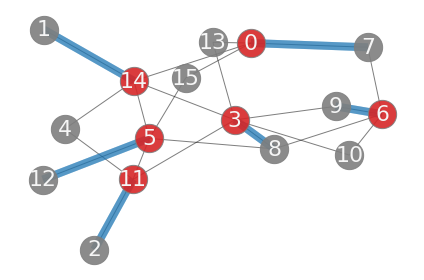

In [21]:
mvc_bg_graph(G, G_sol[0], G_sol[1])

In [22]:
q = QAOA()

In [23]:
vc = MinimumVertexCover(G, field =1.0, penalty=10).get_pubo_problem()

In [24]:
q.compile(vc)

	  ### Summary ###
OpenQAOA has ben compiled with the following properties
Solving QAOA with  vectorized  on  local
Using p=1 with standard parameters initialsied as ramp
OpenQAOA will optimize using cobyla, with up to 100 maximum iterations


In [25]:
q.optimize()

optimization completed.


In [26]:
q.solution

'1001011000010010'

In [27]:
q.solution == mvc_bg_solution(G)[2]

True